# Understanding employee churn

### Import some packages

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import os.path as op
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook', font_scale = 1.5)
sns.set_style('ticks')

# Preproc stuff
###########################
from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, Imputer
from sklearn import feature_selection

# Models
###########################
from sklearn import linear_model
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
                             GradientBoostingClassifier
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier


# CV
###########################
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

# Evaluation
###########################
from sklearn.metrics import mean_squared_error, median_absolute_error, \
                            roc_auc_score, f1_score, precision_score, recall_score

In [2]:
from ml_scripts import *

v5


### Get the data

In [3]:
filepath = '/Users/stephaniesorenson/Dropbox/Work/Insight/data_challenges/employee_retention_data.csv'
df = pd.read_csv(filepath)
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


### Explore the data (briefly!)

In [4]:
# df.employee_id.value_counts() # all of these are unique, so no need to create combo company ids
df.company_id.value_counts()

1     8486
2     4222
3     2749
4     2062
5     1755
6     1291
7     1224
8     1047
9      961
10     865
12      24
11      16
Name: company_id, dtype: int64

In [5]:
df.dept.value_counts()

customer_service    9180
engineer            4613
data_science        3190
sales               3172
marketing           3167
design              1380
Name: dept, dtype: int64

In [6]:
# Look at counts by dept/company
pd.crosstab(df.company_id, df.dept, margins=True)
# company 11 and 12 have few employees

dept,customer_service,data_science,design,engineer,marketing,sales,All
company_id,,,,,,,
1,3157,1079,499,1568,1085,1098,8486
2,1548,568,223,829,541,513,4222
3,1010,347,141,516,372,363,2749
4,777,279,107,376,269,254,2062
5,635,216,108,315,226,255,1755
6,503,153,77,221,175,162,1291
7,469,153,70,227,141,164,1224
8,385,146,53,191,135,137,1047
9,342,134,60,188,124,113,961


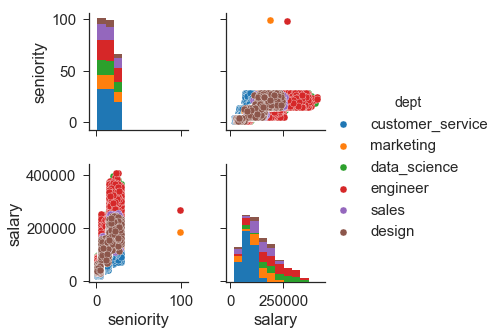

In [7]:
sns.pairplot(df[['seniority', 'salary', 'dept']], hue='dept')

### Preprocess the data

In [8]:
#### Remove the 2 employees with very high seniority
df.loc[df.seniority > 80]
print(df.shape)
df = df.loc[df.seniority < 80]
df.reset_index(inplace=True, drop=True)
print(df.shape)

(24702, 7)
(24700, 7)


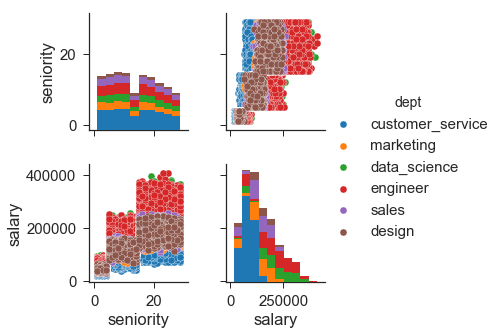

In [9]:
sns.pairplot(df[['seniority', 'salary', 'dept']], hue='dept')

In [10]:
# Log transform salary, since skewed
log_features(df, ['salary'])

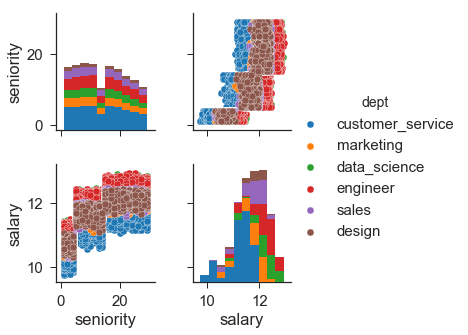

In [11]:
sns.pairplot(df[['seniority', 'salary', 'dept']], hue='dept')

In [12]:
df.dtypes

employee_id    float64
company_id       int64
dept            object
seniority        int64
salary         float64
join_date       object
quit_date       object
dtype: object

In [13]:
df.describe(include='all')

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
count,24700.000000,24700.000000,24700,24700.000000,24700.000000,24700,13508
unique,NaN,NaN,6,NaN,NaN,995,664
top,NaN,NaN,customer_service,NaN,NaN,2012-01-03,2015-05-08
freq,NaN,NaN,9180,NaN,NaN,105,111
mean,501616.624899,3.426802,NaN,14.120972,11.665358,NaN,NaN
std,288908.533280,2.699752,NaN,8.054137,0.621114,NaN,NaN
min,36.000000,1.000000,NaN,1.000000,9.740969,NaN,NaN
25%,250165.250000,1.000000,NaN,7.000000,11.277203,NaN,NaN
50%,500793.000000,2.000000,NaN,14.000000,11.719940,NaN,NaN
75%,753142.250000,5.000000,NaN,21.000000,12.138864,NaN,NaN


In [14]:
# convert dates to datetime type
df['join_date_str'] = df.join_date
df.join_date = pd.to_datetime(df.join_date)
df.quit_date = pd.to_datetime(df.quit_date)
df.dtypes

employee_id             float64
company_id                int64
dept                     object
seniority                 int64
salary                  float64
join_date        datetime64[ns]
quit_date        datetime64[ns]
join_date_str            object
dtype: object

In [15]:
# any nulls? should be some in quit date
print(df.isnull().sum())
# don't have to worry about any imputation!

employee_id          0
company_id           0
dept                 0
seniority            0
salary               0
join_date            0
quit_date        11192
join_date_str        0
dtype: int64


In [16]:
# create a label of whether an employee quit or not (at least yet)
df['left'] = ~df.quit_date.isnull() * 1

In [17]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_date_str,left
0,13021.0,7,customer_service,28,11.396392,2014-03-24,2015-10-30,2014-03-24,1
1,825355.0,7,marketing,20,12.117241,2013-04-29,2014-04-04,2013-04-29,1
2,927315.0,4,marketing,14,11.522876,2014-10-13,NaT,2014-10-13,0
3,662910.0,7,customer_service,20,11.652687,2012-05-14,2013-06-07,2012-05-14,1
4,256971.0,2,data_science,23,12.528156,2011-10-17,2014-08-22,2011-10-17,1


In [18]:
df.left.value_counts()

1    13508
0    11192
Name: left, dtype: int64

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


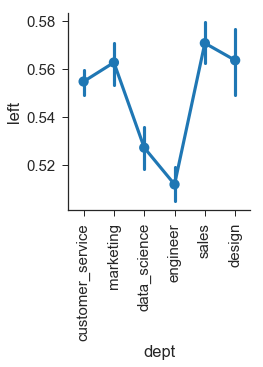

In [19]:
g = sns.factorplot(x = 'dept', y='left', data=df, ci=68)
g.set_xticklabels(rotation=90)

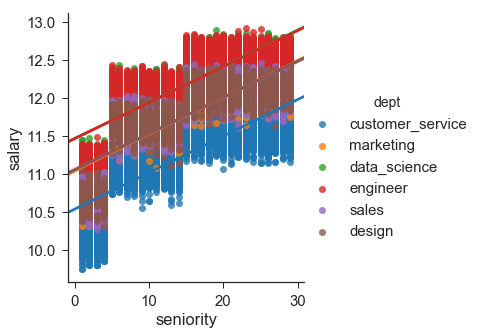

In [20]:
sns.lmplot(x='seniority', y='salary', hue='dept', 
           data=df)

**Insight:** In general, engineers make more than design, who makes more than customer service. DS and sales are more variable. Salary increases with seniority...so need to be careful about correlations between variables in analysis!

## Goal 1: Look at employee headcount over time

You should create a table with 3 columns: day, employee_headcount, company_id.

Head count for a company on a given day is how many customers joined up to that day - how many customers left

#### First, get how many customers joined (new employees) on each day

In [21]:
# new customers per day that they might have joined
new_customers = df.groupby(['company_id', 'join_date']).count().reset_index()[['company_id', 'join_date', 'employee_id']]
new_customers.head()

,company_id,join_date,employee_id
0,1,2011-01-24,25
1,1,2011-01-25,2
2,1,2011-01-26,2
3,1,2011-01-31,30
4,1,2011-02-01,7


In [22]:
# fill in missing dates
# get date in index
new_customers = new_customers.pivot_table(index='join_date', 
                                          columns='company_id', 
                                          values='employee_id', 
                                          fill_value=0, dropna=False)

# now add in missing dates (fill in with zeros, since no one joined)
idx = pd.date_range('2011-01-24', '2015-12-13')
new_customers.index = pd.DatetimeIndex(new_customers.index)
new_customers = new_customers.reindex(idx, fill_value=0)
new_customers.head()

company_id,1,2,3,4,5,6,7,8,9,10,11,12
2011-01-24,25,17,9,12,5,3,1,6,3,0,0,0
2011-01-25,2,2,1,0,0,0,0,0,0,0,0,0
2011-01-26,2,0,2,1,1,0,0,0,0,0,0,0
2011-01-27,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-28,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
new_customers = new_customers.cumsum()

In [24]:
# double check that these are right!
print(df.groupby('company_id').join_date.count())
new_customers.tail()

company_id
1     8485
2     4222
3     2749
4     2062
5     1755
6     1291
7     1224
8     1047
9      961
10     864
11      16
12      24
Name: join_date, dtype: int64


company_id,1,2,3,4,5,6,7,8,9,10,11,12
2015-12-09,8484,4222,2749,2062,1755,1291,1224,1047,961,863,16,24
2015-12-10,8485,4222,2749,2062,1755,1291,1224,1047,961,864,16,24
2015-12-11,8485,4222,2749,2062,1755,1291,1224,1047,961,864,16,24
2015-12-12,8485,4222,2749,2062,1755,1291,1224,1047,961,864,16,24
2015-12-13,8485,4222,2749,2062,1755,1291,1224,1047,961,864,16,24


In [25]:
# move date/time index to column 
new_customers = new_customers.reset_index()
new_customers.rename(columns={'index': 'date'}, inplace=True)

In [26]:
new_customers.head()

company_id,date,1,2,3,4,5,6,7,8,9,10,11,12
0,2011-01-24,25,17,9,12,5,3,1,6,3,0,0,0
1,2011-01-25,27,19,10,12,5,3,1,6,3,0,0,0
2,2011-01-26,29,19,12,13,6,3,1,6,3,0,0,0
3,2011-01-27,29,19,12,13,6,3,1,6,3,0,0,0
4,2011-01-28,29,19,12,13,6,3,1,6,3,0,0,0


In [27]:
new_customers = pd.melt(new_customers, id_vars=['date'], value_name='total_joined')
# new_customers.groupby('company_id').total_joined.max()

In [28]:
new_customers.head()

,date,company_id,total_joined
0,2011-01-24,1,25
1,2011-01-25,1,27
2,2011-01-26,1,29
3,2011-01-27,1,29
4,2011-01-28,1,29


#### Now figure out how many people quit

In [29]:
quit_customers = df.groupby(['company_id', 'quit_date']).count().reset_index()[['company_id', 'quit_date', 'employee_id']]
print(quit_customers.employee_id.sum())
quit_customers.head()

13508


,company_id,quit_date,employee_id
0,1,2011-10-21,1
1,1,2011-11-11,1
2,1,2011-11-22,1
3,1,2011-11-25,1
4,1,2011-12-09,1


In [30]:
# fill in missing dates
# get date in index
quit_customers = quit_customers.pivot_table(index='quit_date', 
                                            columns='company_id', 
                                            values='employee_id', 
                                            fill_value=0, dropna=False)

# now add in missing dates (fill in with zeros, since no one joined)
idx = pd.date_range('2011-01-24', '2015-12-13')
quit_customers.index = pd.DatetimeIndex(quit_customers.index)
quit_customers = quit_customers.reindex(idx, fill_value=0)
quit_customers.head()

company_id,1,2,3,4,5,6,7,8,9,10,11,12
2011-01-24,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-25,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-26,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-27,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-28,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
# get rolling count of how many customers left up to an including that day
quit_customers = quit_customers.cumsum()

In [32]:
# move date/time index to column 
quit_customers = quit_customers.reset_index()
quit_customers.rename(columns={'index': 'date'}, inplace=True)
quit_customers = pd.melt(quit_customers, id_vars=['date'], value_name='total_quit')
quit_customers.head()

,date,company_id,total_quit
0,2011-01-24,1,0
1,2011-01-25,1,0
2,2011-01-26,1,0
3,2011-01-27,1,0
4,2011-01-28,1,0


In [33]:
# quick check that this is right!
print(df.groupby('company_id').left.sum())
quit_customers.groupby('company_id').total_quit.max()

company_id
1     4620
2     2206
3     1531
4     1153
5      983
6      712
7      692
8      579
9      529
10     479
11      12
12      12
Name: left, dtype: int64


company_id
1     4620
2     2206
3     1531
4     1153
5      983
6      712
7      692
8      579
9      529
10     479
11      12
12      12
Name: total_quit, dtype: int64

#### Now merge together to get total headcount on given day

In [34]:
print(new_customers.shape)
print(quit_customers.shape)

(21420, 3)
(21420, 3)


In [35]:
all_customers = new_customers.merge(quit_customers, how='inner')
print(all_customers.shape)
all_customers.head()

(21420, 4)


,date,company_id,total_joined,total_quit
0,2011-01-24,1,25,0
1,2011-01-25,1,27,0
2,2011-01-26,1,29,0
3,2011-01-27,1,29,0
4,2011-01-28,1,29,0


In [36]:
all_customers['employee_headcount'] = all_customers.total_joined - all_customers.total_quit
all_customers.head()

,date,company_id,total_joined,total_quit,employee_headcount
0,2011-01-24,1,25,0,25
1,2011-01-25,1,27,0,27
2,2011-01-26,1,29,0,29
3,2011-01-27,1,29,0,29
4,2011-01-28,1,29,0,29


In [37]:
tab = all_customers.loc[:,['date', 'company_id', 'employee_headcount']]
tab.rename(columns={'date': 'day'}, inplace=True)
tab.head()

,day,company_id,employee_headcount
0,2011-01-24,1,25
1,2011-01-25,1,27
2,2011-01-26,1,29
3,2011-01-27,1,29
4,2011-01-28,1,29


## Goal 2: What are the main factors driving employee churn?

Here, we want to examine which factors might be driving churn. We have info from different companies, including dept, seniority, salary, when they joined (maybe early joiners more likely to stay for longer?)/left. A few things to consider: 

- We can either look at churn for each company separately (factors might differ by company), or just combine across companies. 
- We need to decide what we mean by churn --> eg customers who joined earlier have more time to churn, so it isn't super interesting if more of them have churned

#### How long do quitters tend to stay?

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


4.728767123287671


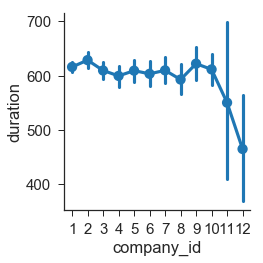

In [38]:
df_quitters = df.loc[df.left == 1]
df_quitters['duration'] = (df_quitters.quit_date - df_quitters.join_date) / np.timedelta64(1, 'D')
print(df_quitters.duration.max() / 365) # this is feasible given timeframe
sns.factorplot(x='company_id', y='duration', data=df_quitters)

### Churn across "larger" companies

For starters, let's just look at churn across all companies (but let's remove the 2 small companies, since their durations are shorter, and they might be different)

In [39]:
print(df.shape)
df_sub = df.loc[~df.company_id.isin([11, 12])]
print(df_sub.shape)

(24700, 9)
(24660, 9)


#### First, let's see how long employees tend to stay

In [40]:
df_sub.quit_date.max() # last quit date

Timestamp('2015-12-09 00:00:00')

In [41]:
# get last observed date for each employee
df_sub['last_date'] = df_sub.quit_date
df_sub.last_date.fillna('2015-12-13', inplace=True)
df_sub.last_date = pd.to_datetime(df_sub.last_date)
df_sub.head()

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_date_str,left,last_date
0,13021.0,7,customer_service,28,11.396392,2014-03-24,2015-10-30,2014-03-24,1,2015-10-30
1,825355.0,7,marketing,20,12.117241,2013-04-29,2014-04-04,2013-04-29,1,2014-04-04
2,927315.0,4,marketing,14,11.522876,2014-10-13,NaT,2014-10-13,0,2015-12-13
3,662910.0,7,customer_service,20,11.652687,2012-05-14,2013-06-07,2012-05-14,1,2013-06-07
4,256971.0,2,data_science,23,12.528156,2011-10-17,2014-08-22,2011-10-17,1,2014-08-22


In [42]:
df_sub['duration'] = (df_sub.last_date - df_sub.join_date) / np.timedelta64(1, 'D')
df_sub.head()

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_date_str,left,last_date,duration
0,13021.0,7,customer_service,28,11.396392,2014-03-24,2015-10-30,2014-03-24,1,2015-10-30,585.0
1,825355.0,7,marketing,20,12.117241,2013-04-29,2014-04-04,2013-04-29,1,2014-04-04,340.0
2,927315.0,4,marketing,14,11.522876,2014-10-13,NaT,2014-10-13,0,2015-12-13,426.0
3,662910.0,7,customer_service,20,11.652687,2012-05-14,2013-06-07,2012-05-14,1,2013-06-07,389.0
4,256971.0,2,data_science,23,12.528156,2011-10-17,2014-08-22,2011-10-17,1,2014-08-22,1040.0


#### Look at survival function

In [43]:
from lifelines.plotting import plot_lifetimes
from lifelines import KaplanMeierFitter

Median days: 732.0


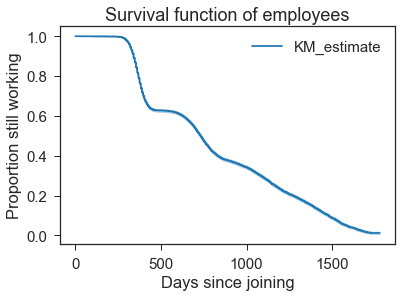

In [44]:
kmf_all = KaplanMeierFitter()

T = df_sub["duration"]
E = df_sub["left"]

kmf_all.fit(T, event_observed=E)
kmf_all.plot()
plt.xlabel('Days since joining')
plt.ylabel('Proportion still working')
plt.title('Survival function of employees')
print('Median days: ' + str(kmf_all.median_))

customer_service
marketing
data_science
engineer
sales
design


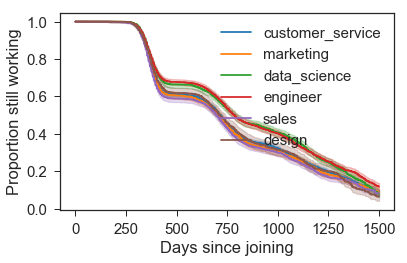

In [45]:
kmf = KaplanMeierFitter()

# Plot by department
t = np.linspace(0, 1500, 1500+1)
ax = plt.subplot(111)

variable = 'dept'
var_levels = list(df_sub[variable].unique())

for var in var_levels:
    print(var)
    label = (df_sub[variable] == var)
    kmf.fit(T[label], event_observed=E[label], 
            timeline=t, label=var)
    kmf.plot(ax=ax)
    
plt.xlabel('Days since joining')
plt.ylabel('Proportion still working')
plt.tight_layout()

**Insight: ** A lot of customers quit around ~500 days, and then around 800 days data scientists/engineers stick around, whereas others drop off 

7
4
2
9
1
6
10
5
3
8


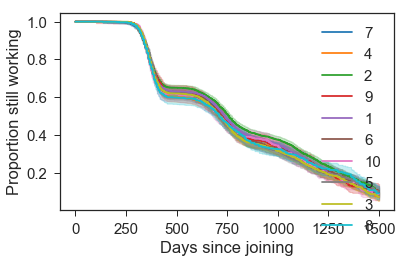

In [46]:
# Plot by company
t = np.linspace(0, 1500, 1500+1)
ax = plt.subplot(111)

variable = 'company_id'
var_levels = list(df_sub[variable].unique())

for var in var_levels:
    print(var)
    label = (df_sub[variable] == var)
    kmf.fit(T[label], event_observed=E[label], 
            timeline=t, label=var)
    kmf.plot(ax=ax)
    
plt.xlabel('Days since joining')
plt.ylabel('Proportion still working')
plt.tight_layout()

**Insight: ** Companies tend to have similar trends in drop off

In [47]:
kmf.median_

711.0

### First, concentrate on what drives people to churn within KMF median days

In [48]:
# get possible duration
df_sub['possible_duration'] = (pd.to_datetime('2015-12-13') - df_sub.join_date) / np.timedelta64(1, 'D')
df_sub.head()

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_date_str,left,last_date,duration,possible_duration
0,13021.0,7,customer_service,28,11.396392,2014-03-24,2015-10-30,2014-03-24,1,2015-10-30,585.0,629.0
1,825355.0,7,marketing,20,12.117241,2013-04-29,2014-04-04,2013-04-29,1,2014-04-04,340.0,958.0
2,927315.0,4,marketing,14,11.522876,2014-10-13,NaT,2014-10-13,0,2015-12-13,426.0,426.0
3,662910.0,7,customer_service,20,11.652687,2012-05-14,2013-06-07,2012-05-14,1,2013-06-07,389.0,1308.0
4,256971.0,2,data_science,23,12.528156,2011-10-17,2014-08-22,2011-10-17,1,2014-08-22,1040.0,1518.0


In [49]:
pd.Series(df_sub.possible_duration > df_sub.duration).value_counts()

True     13484
False    11176
dtype: int64

In [50]:
df_sub['left_ever'] = df_sub.left
df_sub.head()

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_date_str,left,last_date,duration,possible_duration,left_ever
0,13021.0,7,customer_service,28,11.396392,2014-03-24,2015-10-30,2014-03-24,1,2015-10-30,585.0,629.0,1
1,825355.0,7,marketing,20,12.117241,2013-04-29,2014-04-04,2013-04-29,1,2014-04-04,340.0,958.0,1
2,927315.0,4,marketing,14,11.522876,2014-10-13,NaT,2014-10-13,0,2015-12-13,426.0,426.0,0
3,662910.0,7,customer_service,20,11.652687,2012-05-14,2013-06-07,2012-05-14,1,2013-06-07,389.0,1308.0,1
4,256971.0,2,data_science,23,12.528156,2011-10-17,2014-08-22,2011-10-17,1,2014-08-22,1040.0,1518.0,1


To do so, we should exclude active people who haven't had opportunity to quit yet

In [51]:
print(df_sub.shape)
print(df_sub.loc[(df_sub.possible_duration > kmf.median_)].shape)

print(df_sub.shape)
print(df_sub.loc[(df_sub.possible_duration > kmf.median_)].shape)

df_possible = df_sub.loc[(df_sub.possible_duration > kmf.median_)]
df_possible.reset_index(inplace=True, drop=True)
df_possible.shape

df_possible['left'] = (df_possible.duration < kmf.median_) * 1
df_possible.head()

(24660, 13)
(14891, 13)
(24660, 13)
(14891, 13)


(14891, 13)

In [53]:
pd.crosstab(df_possible.left, df_possible.left_ever)

left_ever,0,1
left,,
0,3272,4579
1,0,7040


Some here will leave later, but haven't yet after ~700 days

In [54]:
df_possible.left.value_counts() 

0    7851
1    7040
Name: left, dtype: int64

In [55]:
df_possible.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_date_str,left,last_date,duration,possible_duration,left_ever
0,825355.0,7,marketing,20,12.117241,2013-04-29,2014-04-04,2013-04-29,1,2014-04-04,340.0,958.0,1
1,662910.0,7,customer_service,20,11.652687,2012-05-14,2013-06-07,2012-05-14,1,2013-06-07,389.0,1308.0,1
2,256971.0,2,data_science,23,12.528156,2011-10-17,2014-08-22,2011-10-17,0,2014-08-22,1040.0,1518.0,1
3,509529.0,4,data_science,14,12.013701,2012-01-30,2013-08-30,2012-01-30,1,2013-08-30,578.0,1413.0,1
4,88600.0,4,customer_service,21,11.580584,2013-10-21,NaT,2013-10-21,0,2015-12-13,783.0,783.0,0


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


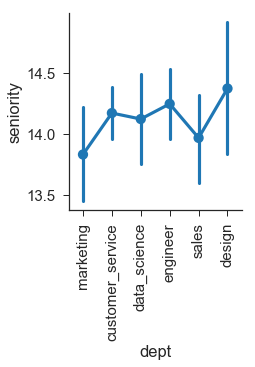

In [56]:
g = sns.factorplot(x='dept', y='seniority', data=df_possible)
g.set_xticklabels(rotation=90)

### First pass modeling the data

Just use basic data, no feature engineering

In [57]:
df_possible.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_date_str,left,last_date,duration,possible_duration,left_ever
0,825355.0,7,marketing,20,12.117241,2013-04-29,2014-04-04,2013-04-29,1,2014-04-04,340.0,958.0,1
1,662910.0,7,customer_service,20,11.652687,2012-05-14,2013-06-07,2012-05-14,1,2013-06-07,389.0,1308.0,1
2,256971.0,2,data_science,23,12.528156,2011-10-17,2014-08-22,2011-10-17,0,2014-08-22,1040.0,1518.0,1
3,509529.0,4,data_science,14,12.013701,2012-01-30,2013-08-30,2012-01-30,1,2013-08-30,578.0,1413.0,1
4,88600.0,4,customer_service,21,11.580584,2013-10-21,NaT,2013-10-21,0,2015-12-13,783.0,783.0,0


In [58]:
d_model = df_possible.copy()
print(d_model.dept.value_counts())

# dummy code dept, and make customer service the base level
d_model, dept_cols  = add_dummies(d_model, 'dept', 'customer_service', 'dept')

# Set up data
y_col = 'left'
dv_type = 'categorical'
scale_cols = ['seniority', 'salary', 'duration']
X = d_model.copy()
y = d_model[y_col]

# remove unnecessary columns
rm_cols = [y_col] + ['last_date', 'join_date_str', 
                     'left_ever', 'possible_duration', 
                     'quit_date', 'join_date', 'company_id', 
                     'employee_id', 'dept']
X.drop(columns=rm_cols, inplace=True)

# drop zero variance cols (eg in case dummy level was dropped)
selector = feature_selection.VarianceThreshold()
selector.fit(X)
cols_zerovariance = X.columns[selector.variances_ == 0]
print('Removing these features w/zero variance...')
print(cols_zerovariance)
X = X.iloc[:, selector.variances_ != 0]

# update scale cols with new subset
updated_scale_cols = [x for x in scale_cols if x not in cols_zerovariance]
print('Scaling these columns:')
print(updated_scale_cols)

# Hold out a segment for final testing
X_build, X_holdout, y_build, y_holdout = \
                    train_test_split(X, y,
                    test_size=0.1,
                    stratify=y if dv_type == 'categorical' else None,
                    random_state=10)
    
# make sure indices are reset
X_build = X_build.reset_index(drop=True)
y_build = y_build.reset_index(drop=True)
print(X_build.head())

########################################
# Fit some models
########################################
dummy = DummyClassifier(strategy='stratified')
logreg = linear_model.LogisticRegression(penalty='l2', C=1.0, 
                                         class_weight='balanced')
rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, 
                            class_weight='balanced')
gboost_class = GradientBoostingClassifier(n_estimators=500, max_depth=6,
                                          max_features='auto',
                                          learning_rate = 0.01)
models = {'dummy': dummy, 
          'Logistic Regression': logreg, 
          'Random Forest': rf, 
          'Gradient boosting': gboost_class}

resample_training = 'over' # upsample to balance classes
n_poly=False
n_cv_folds = 10
scale_x = True

df_eval, feat_imp = fit_evaluate_models(X_build, y_build,
                                        dv_type=dv_type,
                                        models=models,
                                        n_cv_folds=n_cv_folds, scale_x=scale_x,
                                        verbose=True, scale_cols=updated_scale_cols,
                                        n_poly=n_poly,
                                        resample_training=resample_training,
                                        fsel=False)
# melt to longform for plotting
dat = pd.melt(df_eval, id_vars=['model', 'eval_type'])

customer_service    5505
engineer            2781
data_science        1968
sales               1909
marketing           1888
design               840
Name: dept, dtype: int64
(14891, 13)
Added cols:  5
(14891, 18)
Removing these features w/zero variance...
Index([], dtype='object')
Scaling these columns:
['seniority', 'salary', 'duration']
   seniority     salary  duration  dept_data_science  dept_design  \
0         15  12.452933     360.0                  1            0   
1         13  11.571194     774.0                  0            0   
2         10  11.350407     988.0                  0            0   
3          6  11.703546    1363.0                  0            0   
4         23  12.149502     809.0                  1            0   

   dept_engineer  dept_marketing  dept_sales  
0              0               0           0  
1              0               0           1  
2              0               0           0  
3              0               1           0  
4       

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 2 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 3 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 4 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 5 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 6 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 7 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 8 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 9 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 10 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
Scaling X...
Upsampling with SMOTE...
Initializing storage for features
Fitting 
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Fitting 
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=1,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Fitting 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=6,


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


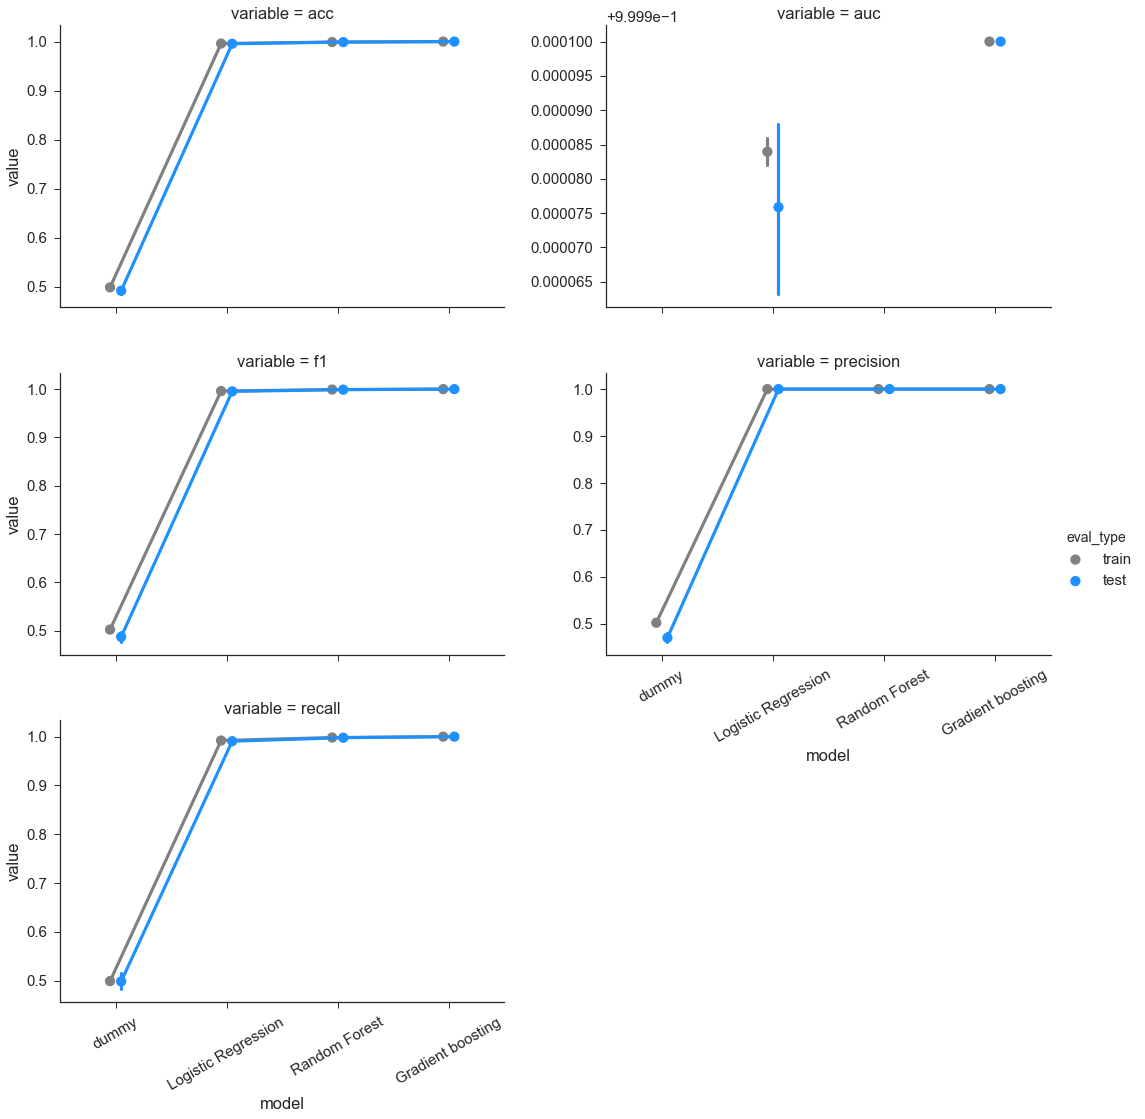

In [59]:
# balanced weights (or nothing for gboost)
g = sns.factorplot(x='model', y='value', col='variable', col_wrap=2,
               hue='eval_type', dodge=.1,
               data=dat, aspect=1.5, size=5, sharey=False,
               palette=['gray', 'dodgerblue'])
g.set_xticklabels(rotation=30)

In general, the ensemble tree-based method (Gradient boosting regression trees) is doing the best in predicting churn, but it's not as interpretable in terms of what's driving churn/retention...

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


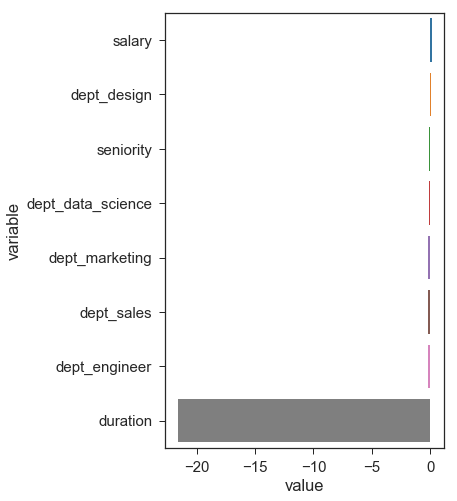

In [60]:
dat = pd.melt(feat_imp.loc[feat_imp.model == 'Logistic Regression'], id_vars='model')
dat.sort_values(by='value', ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=[5, 8])

g = sns.barplot(x='value', y='variable', data=dat)

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,0,'Relative importance')

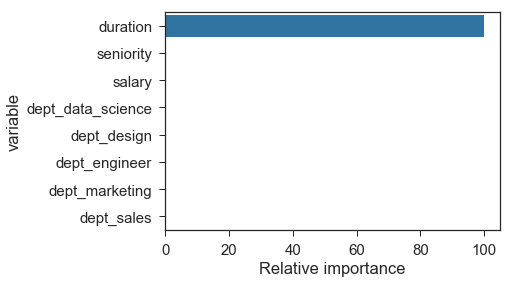

In [61]:
dat = pd.melt(feat_imp.loc[feat_imp.model == 'Gradient boosting'], id_vars='model')

# make importances relative to max importance
dat['value'] = 100.0 * (dat.value / dat.value.max())

# Plot
sns.barplot(x='value', y='variable', data=dat.sort_values(by='value', 
                                                                  ascending=False))
plt.xlabel('Relative importance')

#### Some insights: 

- Even though duration is important, it's not clear that it makes sense to include, since this can't inform hiring decisions (since new employee doesn't have this data yet!)... could get the equivalent by asking them how long they stayed at their old job, but the new job might be different.

### Let's try adding in some other features

#### How many other employees were there when they joined?

In [62]:
df_possible = df_possible.merge(tab, how='left', 
                                left_on=['join_date', 'company_id'], 
                                right_on=['day', 'company_id'])

df_possible.rename(columns={'employee_headcount': 'join_date_headcount'}, inplace=True)

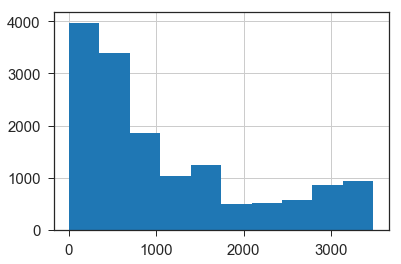

In [64]:
df_possible.join_date_headcount.hist()

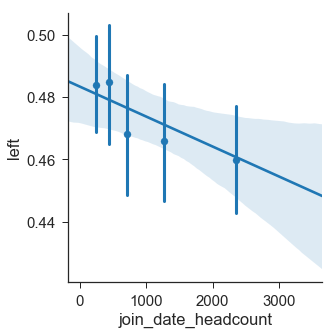

In [65]:
sns.lmplot(y='left', x='join_date_headcount', x_bins=5,
           data=df_possible)

Couuld log transform, or add in quadratic term?

In [66]:
df_possible.join_date_headcount.head()

0    467
1    302
2    615
3    431
4    771
Name: join_date_headcount, dtype: int64

In [67]:
df_possible['join_date_headcount_quad'] = np.square(df_possible.join_date_headcount)

In [68]:
df_possible.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_date_str,left,last_date,duration,possible_duration,left_ever,day,join_date_headcount,join_date_headcount_quad
0,825355.0,7,marketing,20,12.117241,2013-04-29,2014-04-04,2013-04-29,1,2014-04-04,340.0,958.0,1,2013-04-29,467,218089
1,662910.0,7,customer_service,20,11.652687,2012-05-14,2013-06-07,2012-05-14,1,2013-06-07,389.0,1308.0,1,2012-05-14,302,91204
2,256971.0,2,data_science,23,12.528156,2011-10-17,2014-08-22,2011-10-17,0,2014-08-22,1040.0,1518.0,1,2011-10-17,615,378225
3,509529.0,4,data_science,14,12.013701,2012-01-30,2013-08-30,2012-01-30,1,2013-08-30,578.0,1413.0,1,2012-01-30,431,185761
4,88600.0,4,customer_service,21,11.580584,2013-10-21,NaT,2013-10-21,0,2015-12-13,783.0,783.0,0,2013-10-21,771,594441


In [69]:
d_model = df_possible.copy()
print(d_model.dept.value_counts())

# dummy code dept, and make customer service the base level
d_model, dept_cols  = add_dummies(d_model, 'dept', 'customer_service', 'dept')

# Set up data
y_col = 'left'
dv_type = 'categorical'
scale_cols = ['seniority', 'salary', 'join_date_headcount',
             'join_date_headcount_quad']
X = d_model.copy()
y = d_model[y_col]

# remove unnecessary columns
rm_cols = [y_col] + ['duration', 'last_date', 'join_date_str', 
                     'left_ever', 'possible_duration', 
                     'quit_date', 'join_date', 'company_id', 
                     'employee_id', 'dept', 'day']
X.drop(columns=rm_cols, inplace=True)
print(X.head())

# drop zero variance cols (eg in case dummy level was dropped)
selector = feature_selection.VarianceThreshold()
selector.fit(X)
cols_zerovariance = X.columns[selector.variances_ == 0]
print('Removing these features w/zero variance...')
print(cols_zerovariance)
X = X.iloc[:, selector.variances_ != 0]

# update scale cols with new subset
updated_scale_cols = [x for x in scale_cols if x not in cols_zerovariance]
print('Scaling these columns:')
print(updated_scale_cols)

# Hold out a segment for final testing
X_build, X_holdout, y_build, y_holdout = \
                    train_test_split(X, y,
                    test_size=0.1,
                    stratify=y if dv_type == 'categorical' else None,
                    random_state=10)
    
# make sure indices are reset
X_build = X_build.reset_index(drop=True)
y_build = y_build.reset_index(drop=True)
print(X_build.head())

########################################
# Fit some models
########################################
dummy = DummyClassifier(strategy='stratified')
logreg = linear_model.LogisticRegression(penalty='l1', C=10.0, 
                                         class_weight='balanced')
rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, 
                            class_weight='balanced')
gboost_class = GradientBoostingClassifier(n_estimators=500, max_depth=6,
                                          max_features='auto',
                                          learning_rate = 0.01)
models = {'dummy': dummy, 
          'Logistic Regression': logreg, 
          'Random Forest': rf, 
          'Gradient boosting': gboost_class}

resample_training = 'over' # upsample to balance classes
n_poly=False
n_cv_folds = 10
scale_x = True

df_eval, feat_imp = fit_evaluate_models(X_build, y_build,
                                        dv_type=dv_type,
                                        models=models,
                                        n_cv_folds=n_cv_folds, scale_x=scale_x,
                                        verbose=True, scale_cols=updated_scale_cols,
                                        n_poly=n_poly,
                                        resample_training=resample_training,
                                        fsel=False)
# melt to longform for plotting
dat = pd.melt(df_eval, id_vars=['model', 'eval_type'])

customer_service    5505
engineer            2781
data_science        1968
sales               1909
marketing           1888
design               840
Name: dept, dtype: int64
(14891, 16)
Added cols:  5
(14891, 21)
   seniority     salary  join_date_headcount  join_date_headcount_quad  \
0         20  12.117241                  467                    218089   
1         20  11.652687                  302                     91204   
2         23  12.528156                  615                    378225   
3         14  12.013701                  431                    185761   
4         21  11.580584                  771                    594441   

   dept_data_science  dept_design  dept_engineer  dept_marketing  dept_sales  
0                  0            0              0               1           0  
1                  0            0              0               0           0  
2                  1            0              0               0           0  
3                  1     

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 2 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 3 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 4 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 5 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 6 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 7 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 8 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 9 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 10 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
Scaling X...
Upsampling with SMOTE...
Initializing storage for features
Fitting 
LogisticRegression(C=10.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Fitting 
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=1,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Fitting 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=6,

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


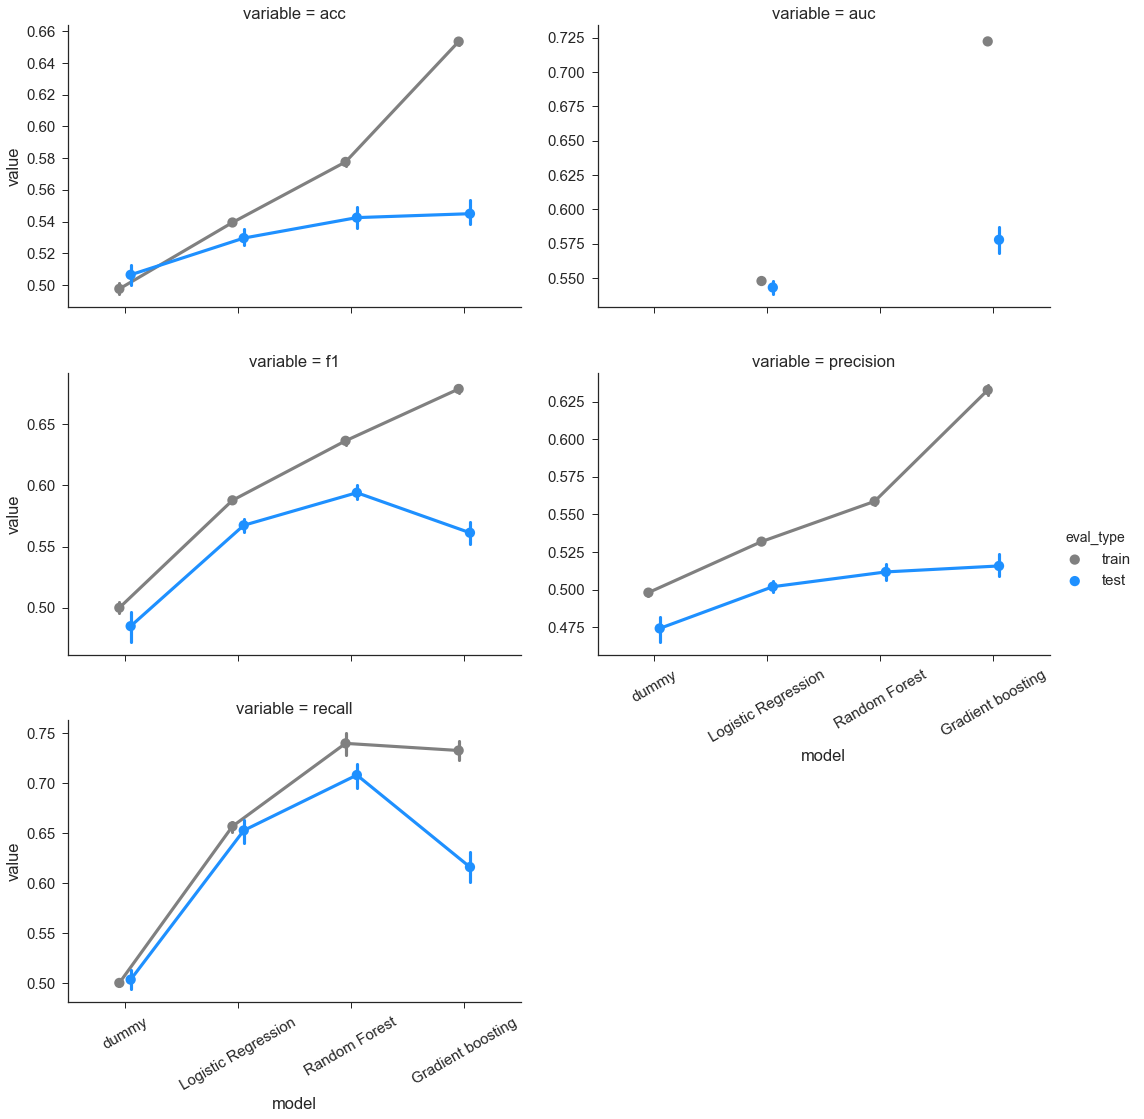

In [70]:
# balanced weights (or nothing for gboost)
g = sns.factorplot(x='model', y='value', col='variable', col_wrap=2,
               hue='eval_type', dodge=.1,
               data=dat, aspect=1.5, size=5, sharey=False,
               palette=['gray', 'dodgerblue'])
g.set_xticklabels(rotation=30)

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


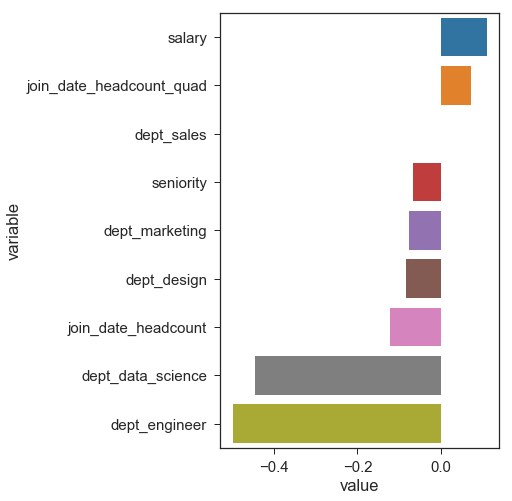

In [72]:
dat = pd.melt(feat_imp.loc[feat_imp.model == 'Logistic Regression'], id_vars='model')
dat.sort_values(by='value', ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=[5, 8])

g = sns.barplot(x='value', y='variable', data=dat)

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,0,'Relative importance')

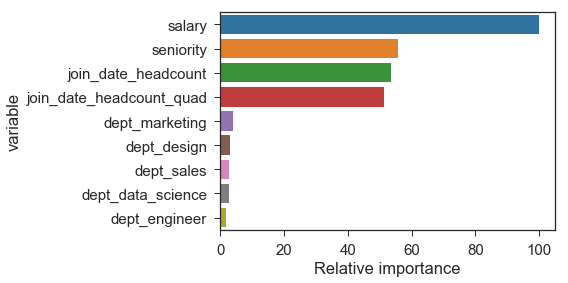

In [73]:
dat = pd.melt(feat_imp.loc[feat_imp.model == 'Gradient boosting'], id_vars='model')

# make importances relative to max importance
dat['value'] = 100.0 * (dat.value / dat.value.max())

# Plot
sns.barplot(x='value', y='variable', data=dat.sort_values(by='value', 
                                                                  ascending=False))
plt.xlabel('Relative importance')

**Insights**:
- Data scientists and engineers tend to stick around for longer than customer service reps (our baseline condition), controlling for salary/seniority
- Employees with higher salaries might be more likely to churn? Is this a non-linear effect? Or is this just the case for customer service reps?

### let's remove seniority from model, since correlated with salary

In [74]:
d_model = df_possible.copy()
print(d_model.dept.value_counts())

# dummy code dept, and make customer service the base level
d_model, dept_cols  = add_dummies(d_model, 'dept', 'customer_service', 'dept')

# Set up data
y_col = 'left'
dv_type = 'categorical'
scale_cols = ['salary', 'join_date_headcount']
X = d_model.copy()
y = d_model[y_col]

# remove unnecessary columns
rm_cols = [y_col] + ['seniority', 'duration', 'last_date', 
                     'join_date_str', 
                     'left_ever', 'possible_duration', 
                     'quit_date', 'join_date', 'company_id', 
                     'employee_id', 'dept', 'day']
X.drop(columns=rm_cols, inplace=True)
print(X.head())

# drop zero variance cols (eg in case dummy level was dropped)
selector = feature_selection.VarianceThreshold()
selector.fit(X)
cols_zerovariance = X.columns[selector.variances_ == 0]
print('Removing these features w/zero variance...')
print(cols_zerovariance)
X = X.iloc[:, selector.variances_ != 0]

# update scale cols with new subset
updated_scale_cols = [x for x in scale_cols if x not in cols_zerovariance]
print('Scaling these columns:')
print(updated_scale_cols)

# Hold out a segment for final testing
X_build, X_holdout, y_build, y_holdout = \
                    train_test_split(X, y,
                    test_size=0.1,
                    stratify=y if dv_type == 'categorical' else None,
                    random_state=10)
    
# make sure indices are reset
X_build = X_build.reset_index(drop=True)
y_build = y_build.reset_index(drop=True)
print(X_build.head())

########################################
# Fit some models
########################################
dummy = DummyClassifier(strategy='stratified')
logreg = linear_model.LogisticRegression(penalty='l1', C=10.0, 
                                         class_weight='balanced')
rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, 
                            class_weight='balanced')
gboost_class = GradientBoostingClassifier(n_estimators=500, max_depth=6,
                                          max_features='auto',
                                          learning_rate = 0.01)
models = {'dummy': dummy, 
          'Logistic Regression': logreg, 
          'Random Forest': rf, 
          'Gradient boosting': gboost_class}

resample_training = 'over' # upsample to balance classes
n_poly=False
n_cv_folds = 10
scale_x = True

df_eval, feat_imp = fit_evaluate_models(X_build, y_build,
                                        dv_type=dv_type,
                                        models=models,
                                        n_cv_folds=n_cv_folds, scale_x=scale_x,
                                        verbose=True, scale_cols=updated_scale_cols,
                                        n_poly=n_poly,
                                        resample_training=resample_training,
                                        fsel=False)
# melt to longform for plotting
dat = pd.melt(df_eval, id_vars=['model', 'eval_type'])

customer_service    5505
engineer            2781
data_science        1968
sales               1909
marketing           1888
design               840
Name: dept, dtype: int64
(14891, 16)
Added cols:  5
(14891, 21)
      salary  join_date_headcount  join_date_headcount_quad  \
0  12.117241                  467                    218089   
1  11.652687                  302                     91204   
2  12.528156                  615                    378225   
3  12.013701                  431                    185761   
4  11.580584                  771                    594441   

   dept_data_science  dept_design  dept_engineer  dept_marketing  dept_sales  
0                  0            0              0               1           0  
1                  0            0              0               0           0  
2                  1            0              0               0           0  
3                  1            0              0               0           0  
4           

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 2 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 3 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 4 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 5 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 6 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 7 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 8 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 9 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 10 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
Scaling X...
Upsampling with SMOTE...
Initializing storage for features
Fitting 
LogisticRegression(C=10.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Fitting 
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=1,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Fitting 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=6,

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


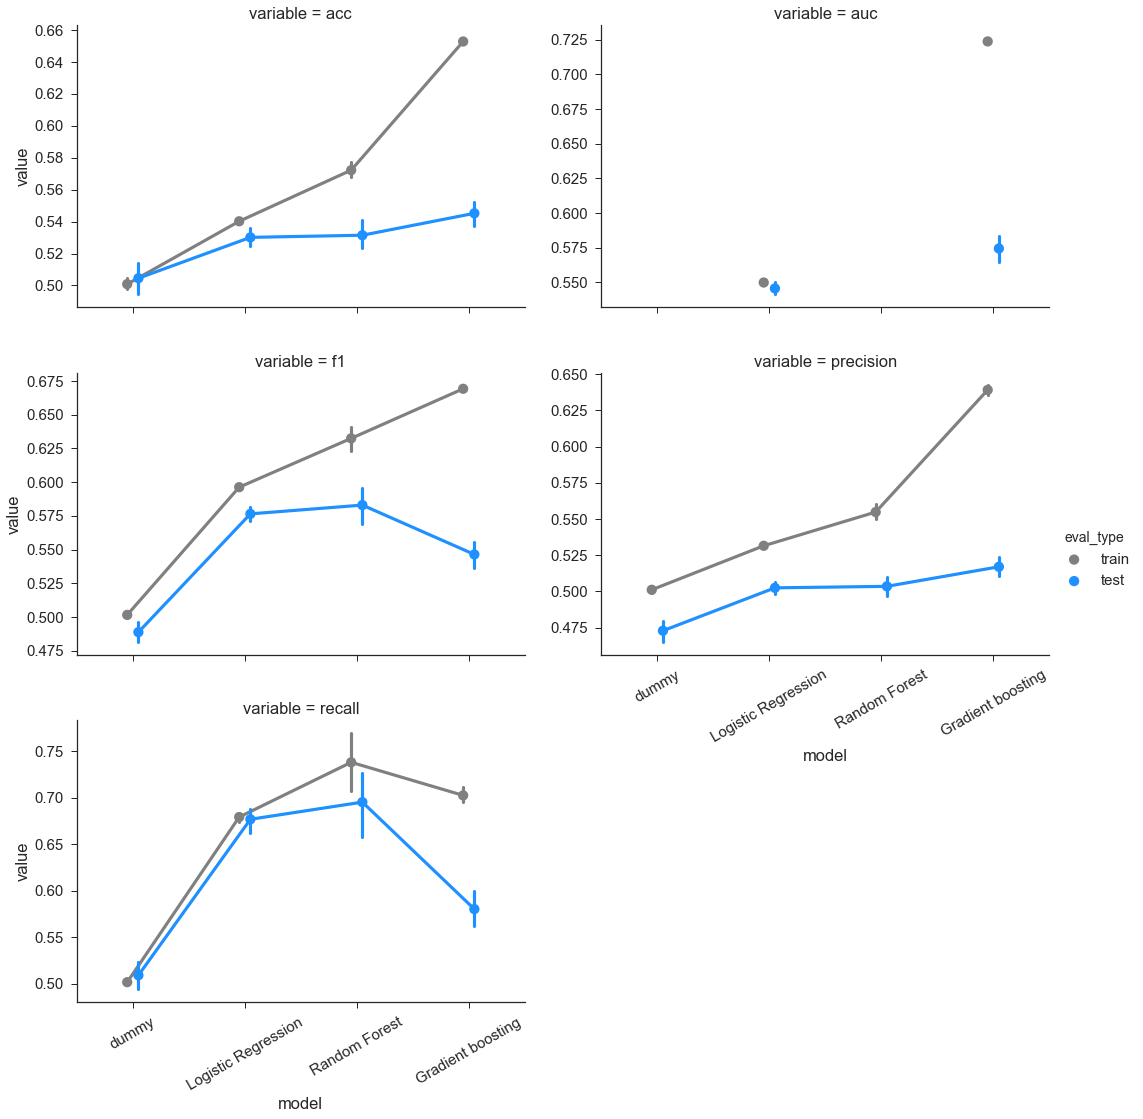

In [75]:
# balanced weights (or nothing for gboost)
g = sns.factorplot(x='model', y='value', col='variable', col_wrap=2,
               hue='eval_type', dodge=.1,
               data=dat, aspect=1.5, size=5, sharey=False,
               palette=['gray', 'dodgerblue'])
g.set_xticklabels(rotation=30)

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


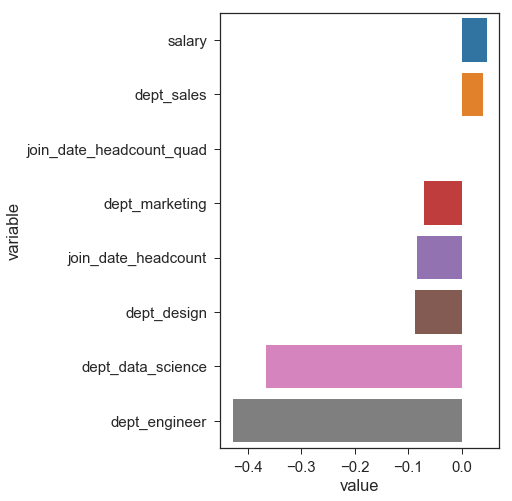

In [76]:
dat = pd.melt(feat_imp.loc[feat_imp.model == 'Logistic Regression'], id_vars='model')
dat.sort_values(by='value', ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=[5, 8])

g = sns.barplot(x='value', y='variable', data=dat)

Basically doing just as well when we remove seniority, and now salary is more interpretable

### Look at interactions quickly in R

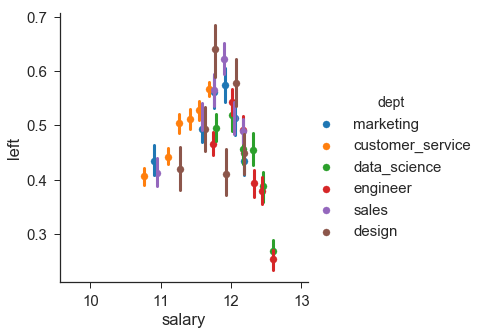

In [77]:
sns.lmplot(x='salary', y='left', hue='dept',
           x_bins=6, fit_reg=False,
           data=df_possible, ci=68)

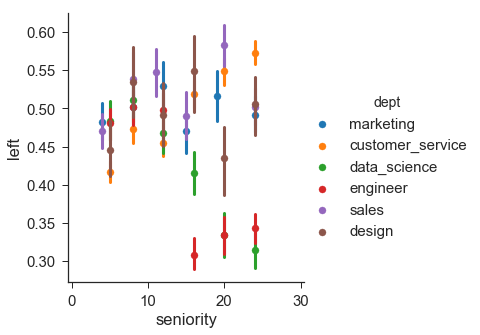

In [78]:
sns.lmplot(x='seniority', y='left', hue='dept',
           x_bins=6, fit_reg=False,
           data=df_possible, ci=68)

In [79]:
%load_ext rpy2.ipython

In [80]:
dat = df_possible[['dept', 'seniority', 'salary', 'left', 'duration', 'join_date_headcount']]
%R -i dat

In [86]:
%%R
print(str(dat))
dat$dept = factor(dat$dept)

# contrast code, so interpreable other vars
contrasts(dat$dept) = contr.sum(length(levels(dat$dept))); print(contrasts(dat$dept))

res = glm(left ~ (poly(salary, 2) + 
                  poly(join_date_headcount, 2)+ 
                  poly(seniority, 2)) * dept,
          family=binomial, data=dat)
summary(res)

'data.frame':	14891 obs. of  6 variables:
 $ dept               : Factor w/ 6 levels "customer_service",..: 5 1 2 2 1 4 6 1 5 5 ...
  ..- attr(*, "contrasts")= num [1:6, 1:5] 1 0 0 0 0 -1 0 1 0 0 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr  "customer_service" "data_science" "design" "engineer" ...
  .. .. ..$ : NULL
 $ seniority          : int  20 20 23 14 21 7 7 13 1 23 ...
 $ salary             : num  12.1 11.7 12.5 12 11.6 ...
 $ left               : int  1 1 0 1 0 0 0 0 1 0 ...
 $ duration           : num  340 389 1040 578 783 ...
 $ join_date_headcount: int  467 302 615 431 771 298 2193 386 2725 221 ...
NULL
                 [,1] [,2] [,3] [,4] [,5]
customer_service    1    0    0    0    0
data_science        0    1    0    0    0
design              0    0    1    0    0
engineer            0    0    0    1    0
marketing           0    0    0    0    1
sales              -1   -1   -1   -1   -1

Call:
glm(formula = left ~ (poly(salary, 2) + poly(join_date_headco

Maybe some interactions -- if in customer service, increases in salary make them more likely to leave (raise at diff job?), but for DS, higher salaries mean less likely to leave...

## What drives churn within a year?

In [93]:
print(df_sub.shape)
print(df_sub.loc[(df_sub.possible_duration > 365)].shape)

df_possible = df_sub.loc[(df_sub.possible_duration > 365)]
df_possible.reset_index(inplace=True, drop=True)
df_possible.shape

df_possible['left'] = (df_possible.duration < 365) * 1

df_possible = df_possible.merge(tab, how='left', 
                                left_on=['join_date', 'company_id'], 
                                right_on=['day', 'company_id'])

df_possible.rename(columns={'employee_headcount': 'join_date_headcount'}, inplace=True)
df_possible['join_date_headcount_quad'] = np.square(df_possible.join_date_headcount)
df_possible.head()

(24660, 13)
(19622, 13)


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_date_str,left,last_date,duration,possible_duration,left_ever,day,join_date_headcount,join_date_headcount_quad
0,13021.0,7,customer_service,28,11.396392,2014-03-24,2015-10-30,2014-03-24,0,2015-10-30,585.0,629.0,1,2014-03-24,522,272484
1,825355.0,7,marketing,20,12.117241,2013-04-29,2014-04-04,2013-04-29,1,2014-04-04,340.0,958.0,1,2013-04-29,467,218089
2,927315.0,4,marketing,14,11.522876,2014-10-13,NaT,2014-10-13,0,2015-12-13,426.0,426.0,0,2014-10-13,932,868624
3,662910.0,7,customer_service,20,11.652687,2012-05-14,2013-06-07,2012-05-14,0,2013-06-07,389.0,1308.0,1,2012-05-14,302,91204
4,256971.0,2,data_science,23,12.528156,2011-10-17,2014-08-22,2011-10-17,0,2014-08-22,1040.0,1518.0,1,2011-10-17,615,378225


In [97]:
print(d_model.left.value_counts())

0    16035
1     3587
Name: left, dtype: int64


In [94]:
d_model = df_possible.copy()
print(d_model.dept.value_counts())

# dummy code dept, and make customer service the base level
d_model, dept_cols  = add_dummies(d_model, 'dept', 'customer_service', 'dept')

# Set up data
y_col = 'left'
dv_type = 'categorical'
scale_cols = ['salary', 'join_date_headcount']
X = d_model.copy()
y = d_model[y_col]

# remove unnecessary columns
rm_cols = [y_col] + ['seniority', 'duration', 'last_date', 
                     'join_date_str', 
                     'left_ever', 'possible_duration', 
                     'quit_date', 'join_date', 'company_id', 
                     'employee_id', 'dept', 'day']
X.drop(columns=rm_cols, inplace=True)
print(X.head())

# drop zero variance cols (eg in case dummy level was dropped)
selector = feature_selection.VarianceThreshold()
selector.fit(X)
cols_zerovariance = X.columns[selector.variances_ == 0]
print('Removing these features w/zero variance...')
print(cols_zerovariance)
X = X.iloc[:, selector.variances_ != 0]

# update scale cols with new subset
updated_scale_cols = [x for x in scale_cols if x not in cols_zerovariance]
print('Scaling these columns:')
print(updated_scale_cols)

# Hold out a segment for final testing
X_build, X_holdout, y_build, y_holdout = \
                    train_test_split(X, y,
                    test_size=0.1,
                    stratify=y if dv_type == 'categorical' else None,
                    random_state=10)
    
# make sure indices are reset
X_build = X_build.reset_index(drop=True)
y_build = y_build.reset_index(drop=True)
print(X_build.head())

########################################
# Fit some models
########################################
dummy = DummyClassifier(strategy='stratified')
logreg = linear_model.LogisticRegression(penalty='l1', C=10.0, 
                                         class_weight='balanced')
rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, 
                            class_weight='balanced')
gboost_class = GradientBoostingClassifier(n_estimators=500, max_depth=6,
                                          max_features='auto',
                                          learning_rate = 0.01)
models = {'dummy': dummy, 
          'Logistic Regression': logreg, 
          'Random Forest': rf, 
          'Gradient boosting': gboost_class}

resample_training = 'over' # upsample to balance classes
n_poly=False
n_cv_folds = 10
scale_x = True

df_eval, feat_imp = fit_evaluate_models(X_build, y_build,
                                        dv_type=dv_type,
                                        models=models,
                                        n_cv_folds=n_cv_folds, scale_x=scale_x,
                                        verbose=True, scale_cols=updated_scale_cols,
                                        n_poly=n_poly,
                                        resample_training=resample_training,
                                        fsel=False)
# melt to longform for plotting
dat = pd.melt(df_eval, id_vars=['model', 'eval_type'])

customer_service    7229
engineer            3654
data_science        2577
sales               2546
marketing           2499
design              1117
Name: dept, dtype: int64
(19622, 16)
Added cols:  5
(19622, 21)
      salary  join_date_headcount  join_date_headcount_quad  \
0  11.396392                  522                    272484   
1  12.117241                  467                    218089   
2  11.522876                  932                    868624   
3  11.652687                  302                     91204   
4  12.528156                  615                    378225   

   dept_data_science  dept_design  dept_engineer  dept_marketing  dept_sales  
0                  0            0              0               0           0  
1                  0            0              0               1           0  
2                  0            0              0               1           0  
3                  0            0              0               0           0  
4           

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 2 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 3 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 4 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 5 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 6 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 7 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 8 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 9 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 10 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
Scaling X...
Upsampling with SMOTE...
Initializing storage for features
Fitting 
LogisticRegression(C=10.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Fitting 
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=1,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Fitting 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=6,

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


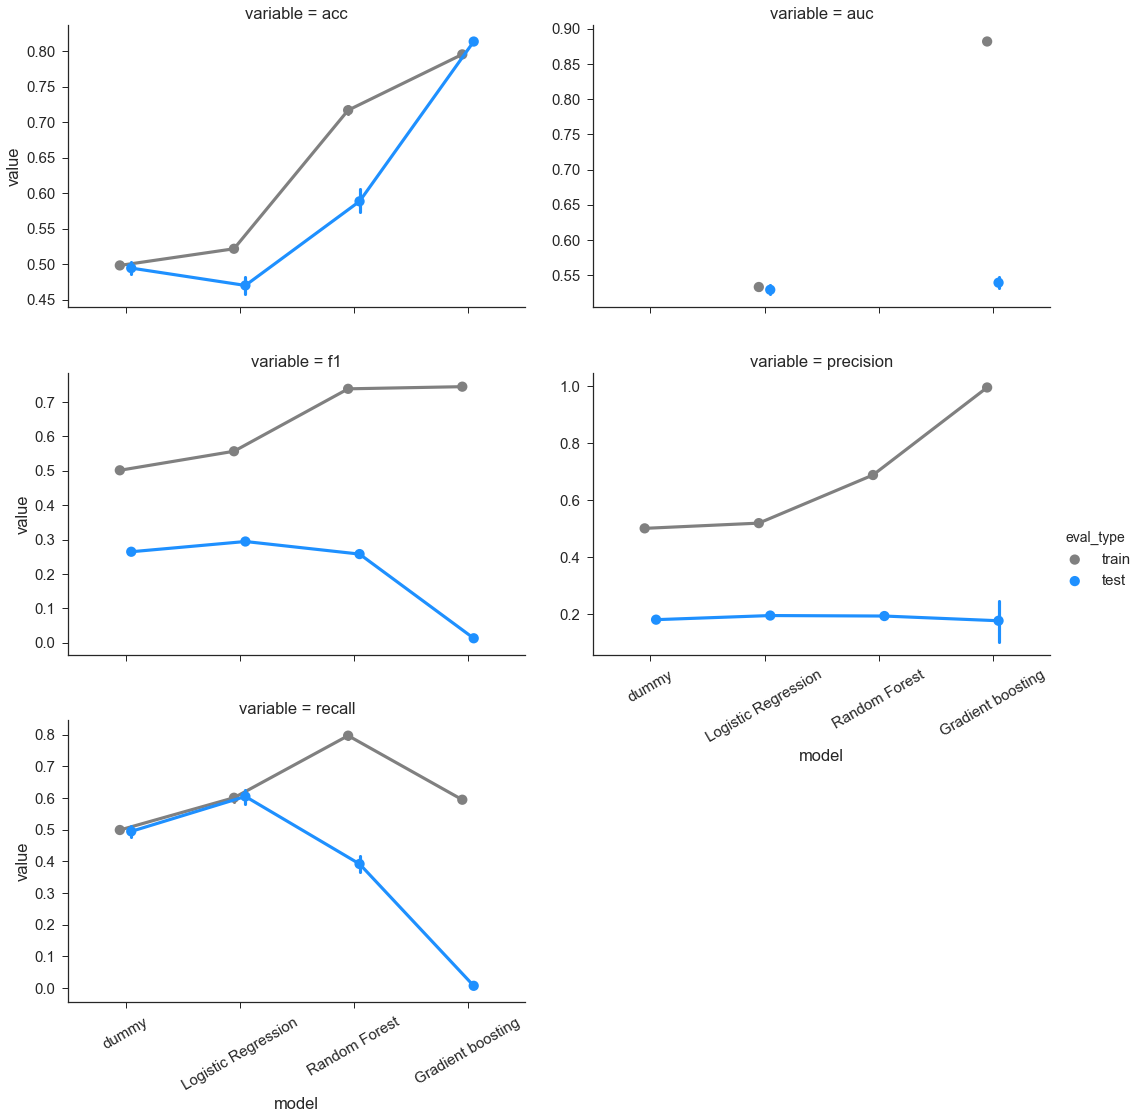

In [95]:
# balanced weights (or nothing for gboost)
g = sns.factorplot(x='model', y='value', col='variable', col_wrap=2,
               hue='eval_type', dodge=.1,
               data=dat, aspect=1.5, size=5, sharey=False,
               palette=['gray', 'dodgerblue'])
g.set_xticklabels(rotation=30)

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


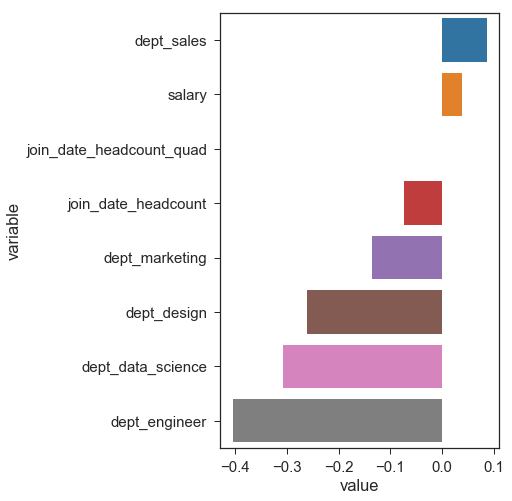

In [96]:
dat = pd.melt(feat_imp.loc[feat_imp.model == 'Logistic Regression'], id_vars='model')
dat.sort_values(by='value', ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=[5, 8])

g = sns.barplot(x='value', y='variable', data=dat)

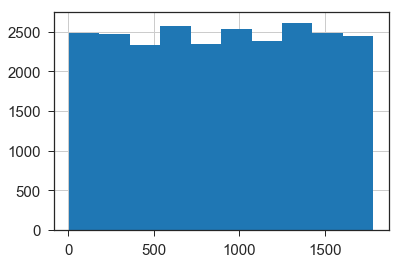

In [98]:
df_sub.possible_duration.hist()

### What drives churn after 3 years?

In [101]:
print(df_sub.shape)
print(df_sub.loc[(df_sub.possible_duration > (365*3))].shape)

df_possible = df_sub.loc[(df_sub.possible_duration > (365*3))]
df_possible.reset_index(inplace=True, drop=True)
df_possible.shape

df_possible['left'] = (df_possible.duration < (365*3)) * 1

df_possible = df_possible.merge(tab, how='left', 
                                left_on=['join_date', 'company_id'], 
                                right_on=['day', 'company_id'])

df_possible.rename(columns={'employee_headcount': 'join_date_headcount'}, inplace=True)
df_possible['join_date_headcount_quad'] = np.square(df_possible.join_date_headcount)
df_possible.head()

d_model = df_possible.copy()
print(d_model.dept.value_counts())

# dummy code dept, and make customer service the base level
d_model, dept_cols  = add_dummies(d_model, 'dept', 'customer_service', 'dept')

# Set up data
y_col = 'left'
dv_type = 'categorical'
scale_cols = ['salary', 'join_date_headcount']
X = d_model.copy()
y = d_model[y_col]

# remove unnecessary columns
rm_cols = [y_col] + ['seniority', 'duration', 'last_date', 
                     'join_date_str', 
                     'left_ever', 'possible_duration', 
                     'quit_date', 'join_date', 'company_id', 
                     'employee_id', 'dept', 'day']
X.drop(columns=rm_cols, inplace=True)
print(X.head())

# drop zero variance cols (eg in case dummy level was dropped)
selector = feature_selection.VarianceThreshold()
selector.fit(X)
cols_zerovariance = X.columns[selector.variances_ == 0]
print('Removing these features w/zero variance...')
print(cols_zerovariance)
X = X.iloc[:, selector.variances_ != 0]

# update scale cols with new subset
updated_scale_cols = [x for x in scale_cols if x not in cols_zerovariance]
print('Scaling these columns:')
print(updated_scale_cols)

# Hold out a segment for final testing
X_build, X_holdout, y_build, y_holdout = \
                    train_test_split(X, y,
                    test_size=0.1,
                    stratify=y if dv_type == 'categorical' else None,
                    random_state=10)
    
# make sure indices are reset
X_build = X_build.reset_index(drop=True)
y_build = y_build.reset_index(drop=True)
print(X_build.head())

########################################
# Fit some models
########################################
dummy = DummyClassifier(strategy='stratified')
logreg = linear_model.LogisticRegression(penalty='l1', C=10.0, 
                                         class_weight='balanced')
rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, 
                            class_weight='balanced')
gboost_class = GradientBoostingClassifier(n_estimators=500, max_depth=6,
                                          max_features='auto',
                                          learning_rate = 0.01)
models = {'dummy': dummy, 
          'Logistic Regression': logreg, 
          'Random Forest': rf, 
          'Gradient boosting': gboost_class}

resample_training = 'over' # upsample to balance classes
n_poly=False
n_cv_folds = 10
scale_x = True

df_eval, feat_imp = fit_evaluate_models(X_build, y_build,
                                        dv_type=dv_type,
                                        models=models,
                                        n_cv_folds=n_cv_folds, scale_x=scale_x,
                                        verbose=True, scale_cols=updated_scale_cols,
                                        n_poly=n_poly,
                                        resample_training=resample_training,
                                        fsel=False)
# melt to longform for plotting
dat = pd.melt(df_eval, id_vars=['model', 'eval_type'])

(24660, 13)
(9619, 13)
customer_service    3570
engineer            1777
data_science        1265
marketing           1246
sales               1224
design               537
Name: dept, dtype: int64
(9619, 16)
Added cols:  5
(9619, 21)
      salary  join_date_headcount  join_date_headcount_quad  \
0  11.652687                  302                     91204   
1  12.528156                  615                    378225   
2  12.013701                  431                    185761   
3  11.982929                  298                     88804   
4  11.552146                 2193                   4809249   

   dept_data_science  dept_design  dept_engineer  dept_marketing  dept_sales  
0                  0            0              0               0           0  
1                  1            0              0               0           0  
2                  1            0              0               0           0  
3                  0            0              1               0      

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 2 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 3 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 4 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 5 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 6 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 7 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 8 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 9 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
CV fold 10 ...
Scaling X...


/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Upsampling with SMOTE...
dummy
Logistic Regression
Random Forest
Gradient boosting
Scaling X...
Upsampling with SMOTE...
Initializing storage for features
Fitting 
LogisticRegression(C=10.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Fitting 
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=1,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Fitting 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=6,

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


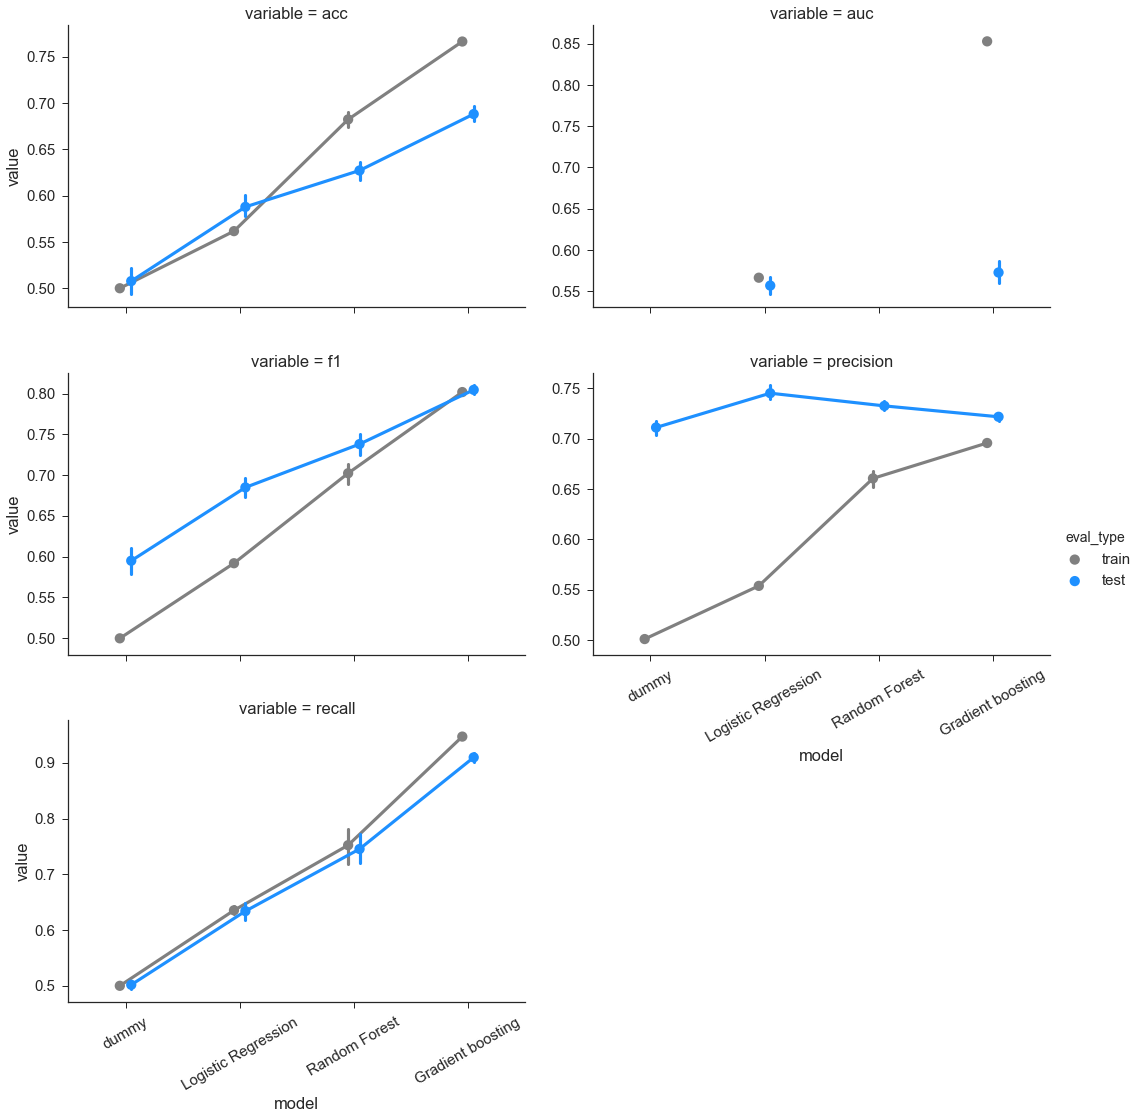

In [102]:
# balanced weights (or nothing for gboost)
g = sns.factorplot(x='model', y='value', col='variable', col_wrap=2,
               hue='eval_type', dodge=.1,
               data=dat, aspect=1.5, size=5, sharey=False,
               palette=['gray', 'dodgerblue'])
g.set_xticklabels(rotation=30)

/Users/stephaniesorenson/anaconda3/envs/insightenv/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


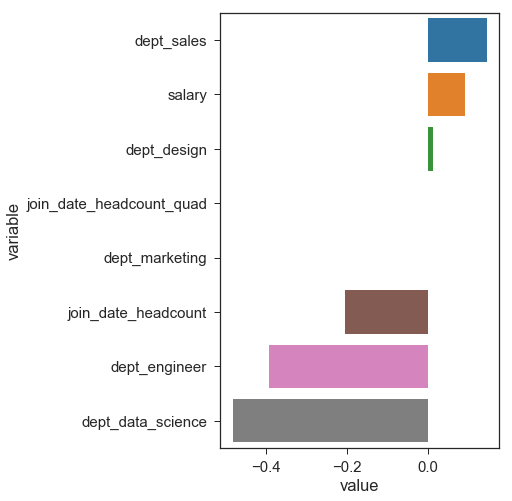

In [103]:
dat = pd.melt(feat_imp.loc[feat_imp.model == 'Logistic Regression'], id_vars='model')
dat.sort_values(by='value', ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=[5, 8])

g = sns.barplot(x='value', y='variable', data=dat)

# Summary: factors driving employee churn

The main factors influencing whether an employee will churn within ~700 days (median "lifespan" -- ~2 years):

1. When an employee joins, if the employee headcount is relatively higher, the employee is more likely to stay. Maybe bigger companies have established HR departments, who can help keep customers happy. Also, companies with smaller headcounts -- might be startups/have a faster workpace, and people might burn out sooner and quit to seek out new job.

2. In general, data scientists and engineers tend to stay for longer than customer service reps -- this is particularly the case if you're looking at people who quit vs. stay after ~800 days.

3. There are some interactions between salary and department that might be worth following up on


**Other**:
- From what I've examined, these factors don't really inform who will churn within a year

## Goal 3: What is one variable that could help explain employee churn?

The first variable I would add to this data set is **General employee happiness/job satisfaction measured after ~200 days** (before the first group of quitters starts to leave).


Additionally, a few other variables that might help explain employee churn:
- Number of hours worked per week
- Performance reviews (e.g., if they're doing relatively well/poorly)
- Team size
- Rating of manager 
- Number of projects completed
- How long they were at previous job
- Straight from college or employed previously
- Age